In [1]:
%load_ext autoreload
%load_ext autotime

time: 374 µs (started: 2023-09-22 12:51:25 -07:00)


In [2]:
import os
import sys
wisio_dir = os.path.abspath("../")
sys.path.append(wisio_dir)
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

time: 1.06 s (started: 2023-09-22 12:51:26 -07:00)


In [3]:
import dask.dataframe as dd
import numpy as np
import pandas as pd


time: 1.54 s (started: 2023-09-22 12:51:27 -07:00)


In [4]:
%autoreload 2

from wisio.recorder import RecorderAnalyzer

log_dir = "/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet"

recorder_analyzer = RecorderAnalyzer(
    cluster_manager_args=dict(
        force_local=True,
        cluster_settings=dict(
            cores=4,
            dashboard_port=3646,
            local_directory="/var/tmp/wisio-recorder-cm1",
            log_file="%J.log",
            worker_queue="pdebug"
        )
    ),
    working_dir='.recorder',
    debug=True
) 

recorder_analyzer

time: 3.01 s (started: 2023-09-22 12:51:28 -07:00)


In [5]:
client = recorder_analyzer.cluster_manager.clients[0]
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.132.130:3646/status,
Dashboard: http://192.168.132.130:3646/status,Workers: 4
Total threads: 36,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://192.168.132.130:38457,Workers: 4
Dashboard: http://192.168.132.130:3646/status,Total threads: 36
Started: Just now,Total memory: 0 B
Comm: tcp://192.168.132.130:43195,Total threads: 9
Dashboard: http://192.168.132.130:35137/status,Memory: 0 B
Nanny: tcp://192.168.132.130:45869,


time: 47.8 ms (started: 2023-09-22 12:51:31 -07:00)


In [6]:
%autoreload 2

res = recorder_analyzer.analyze_parquet(log_dir=log_dir, checkpoint=False, metrics=['duration'], cutoff=0)

{'duration': {('time_range',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}}}
{'duration': {('time_range',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}, ('file_name',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}}}
{'duration': {('time_range',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}, ('file_name',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}, ('proc_name',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}}}
{'duration': {('time_range',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_records': dd.Scalar<series-..., dtype=int64>}, ('file_name',): {'metric_max': dd.Scalar<series-..., dtype=float64>, 'total_

In [7]:
time_range_group_view = res.group_views['duration'][('time_range',)].compute()
time_range_group_view

,bw,data_count,duration_sum,index_count,intensity,iops,size_sum,att_perf,total_records,duration_csp,duration_delta,index_count_csp,duration_sum_sum,index_count_sum,io_per,index_count_per,io_per_rev,index_count_per_rev,angle
time_range,,,,,,,,,,,,,,,,,,,
5,0.000000e+00,0,2.191843,1,0.000000e+00,0.000000,0,0.000000,15034,1.000000,1.000000,1,5.854984,15034,0.625645,0.999933,0.374355,0.000067,57.966339
634,6.796889e+05,6,0.328102,40,1.793666e-04,18.287018,223007,76335.879579,15034,1.149692,0.149692,41,5.854984,15034,0.943962,0.997273,0.430393,0.002727,60.266523
668,4.632067e+09,19,0.277307,96,6.568404e-07,602.167168,146154226,32258.064952,15034,1.276210,0.126518,137,5.854984,15034,0.952637,0.990887,0.477756,0.009113,62.208652
450,4.722834e+09,19,0.240101,78,5.336828e-07,613.966768,146154226,29585.799628,15034,1.385753,0.109543,215,5.854984,15034,0.958992,0.985699,0.518764,0.014301,63.977520
128,1.379437e+09,5,0.201961,33,1.964283e-06,410.546094,16800021,52356.021168,15034,1.477895,0.092142,248,5.854984,15034,0.965506,0.983504,0.553258,0.016496,65.570764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1.858062e+08,4,0.000670,18,1.446329e-04,5971.932015,124453,16638.935317,15034,2.670124,0.000306,14962,5.854984,15034,0.999886,0.004789,0.999574,0.995211,84.922575
617,1.967636e+08,4,0.000632,18,1.446329e-04,6324.110700,124453,20876.826314,15034,2.670413,0.000289,14980,5.854984,15034,0.999892,0.003592,0.999683,0.996408,84.948661
12,1.981420e+08,4,0.000628,18,1.446329e-04,6368.412668,124453,21276.595129,15034,2.670699,0.000287,14998,5.854984,15034,0.999893,0.002395,0.999790,0.997605,84.982995


time: 141 ms (started: 2023-09-22 12:51:39 -07:00)


In [8]:
time_range_group_view[time_range_group_view['angle'] > 75].head()

,bw,data_count,duration_sum,index_count,intensity,iops,size_sum,att_perf,total_records,duration_csp,duration_delta,index_count_csp,duration_sum_sum,index_count_sum,io_per,index_count_per,angle
time_range,,,,,,,,,,,,,,,,,
448,7.573911e+07,6,0.002578,40,0.000205,2327.295306,195263,76335.879579,15034,2.562576,0.001176,11018,5.854984,15034,0.99956,0.267128,75.037623
264,6.500291e+07,6,0.002577,40,0.000239,2328.198387,167519,82644.626211,15034,2.563752,0.001176,11058,5.854984,15034,0.99956,0.264467,75.180064
228,6.294575e+07,6,0.002575,40,0.000247,2330.187603,162079,84033.615825,15034,2.564927,0.001175,11098,5.854984,15034,0.99956,0.261807,75.322695
327,6.854973e+07,6,0.002575,40,0.000227,2330.368562,176495,76335.879579,15034,2.566102,0.001175,11138,5.854984,15034,0.99956,0.259146,75.465508
507,7.934385e+07,6,0.002574,40,0.000196,2330.911754,204239,76335.879579,15034,2.567276,0.001174,11178,5.854984,15034,0.99956,0.256485,75.608507


time: 19.7 ms (started: 2023-09-22 12:30:33 -07:00)


In [9]:
time_range_group_view[time_range_group_view['angle'] < 75]

,bw,data_count,duration_sum,index_count,intensity,iops,size_sum,att_perf,total_records,duration_csp,duration_delta,index_count_csp,duration_sum_sum,index_count_sum,io_per,index_count_per,angle
time_range,,,,,,,,,,,,,,,,,
5,0.000000e+00,0,2.191843,1,0.000000e+00,0.000000,0,0.000000,15034,1.000000,1.000000,1,5.854984,15034,0.625645,0.999933,32.033661
634,6.796889e+05,6,0.328102,40,1.793666e-04,18.287018,223007,76335.879579,15034,1.149692,0.149692,41,5.854984,15034,0.943962,0.997273,43.426919
668,4.632067e+09,19,0.277307,96,6.568404e-07,602.167168,146154226,32258.064952,15034,1.276210,0.126518,137,5.854984,15034,0.952637,0.990887,43.872527
450,4.722834e+09,19,0.240101,78,5.336828e-07,613.966768,146154226,29585.799628,15034,1.385753,0.109543,215,5.854984,15034,0.958992,0.985699,44.213187
128,1.379437e+09,5,0.201961,33,1.964283e-06,410.546094,16800021,52356.021168,15034,1.477895,0.092142,248,5.854984,15034,0.965506,0.983504,44.470922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,6.742445e+07,6,0.002597,40,2.283952e-04,2309.913393,175135,84033.615825,15034,2.556678,0.001185,10818,5.854984,15034,0.999556,0.280431,74.328245
178,5.942079e+07,6,0.002595,40,2.594185e-04,2312.227861,154191,82644.626211,15034,2.557862,0.001184,10858,5.854984,15034,0.999557,0.277770,74.469731
255,6.421356e+07,6,0.002588,40,2.407333e-04,2318.751010,166159,84033.615825,15034,2.559043,0.001181,10898,5.854984,15034,0.999558,0.275110,74.611424


time: 24.6 ms (started: 2023-09-22 12:30:42 -07:00)


In [8]:
# time_range_group_view['io_per_rev'] = (1 - time_range_group_view['io_per']).cumsum()
# time_range_group_view['index_count_per_rev'] = 1 - time_range_group_view['index_count_per']
time_range_group_view2 = time_range_group_view[['io_per_rev', 'index_count_per_rev', 'angle']]
# time_range_group_view2 = time_range_group_view2[time_range_group_view2['angle'] <= 45]
time_range_group_view2

,io_per_rev,index_count_per_rev,angle
time_range,,,
5,0.374355,0.000067,57.966339
634,0.430393,0.002727,60.266523
668,0.477756,0.009113,62.208652
450,0.518764,0.014301,63.977520
128,0.553258,0.016496,65.570764
...,...,...,...
553,0.999574,0.995211,84.922575
617,0.999683,0.996408,84.948661
12,0.999790,0.997605,84.982995


time: 11.5 ms (started: 2023-09-22 12:51:40 -07:00)


In [14]:
time_range_group_view2['io_per_d'] = time_range_group_view2['io_per_rev'].diff()
time_range_group_view2['index_count_per_d'] = time_range_group_view2['index_count_per_rev'].diff()
time_range_group_view2['angle2'] = np.rad2deg(np.arctan2(time_range_group_view2['index_count_per_d'], time_range_group_view2['io_per_d']))
time_range_group_view2['angle2'] = time_range_group_view2['angle2'].fillna(0)
time_range_group_view2

,io_per_rev,index_count_per_rev,angle,io_per_d,index_count_per_d,angle2
time_range,,,,,,
5,0.374355,0.000067,57.966339,NaN,NaN,0.000000
634,0.430393,0.002727,60.266523,0.056038,0.002661,2.718313
668,0.477756,0.009113,62.208652,0.047363,0.006386,7.678453
450,0.518764,0.014301,63.977520,0.041008,0.005188,7.210622
128,0.553258,0.016496,65.570764,0.034494,0.002195,3.641115
...,...,...,...,...,...,...
553,0.999574,0.995211,84.922575,0.000114,0.001197,84.542073
617,0.999683,0.996408,84.948661,0.000108,0.001197,84.844330
12,0.999790,0.997605,84.982995,0.000107,0.001197,84.880004


time: 16.6 ms (started: 2023-09-22 13:01:49 -07:00)


In [15]:
time_range_group_view2[time_range_group_view2['angle2'] < 50]

,io_per_rev,index_count_per_rev,angle,io_per_d,index_count_per_d,angle2
time_range,,,,,,
5,0.374355,0.000067,57.966339,NaN,NaN,0.000000
634,0.430393,0.002727,60.266523,0.056038,0.002661,2.718313
668,0.477756,0.009113,62.208652,0.047363,0.006386,7.678453
450,0.518764,0.014301,63.977520,0.041008,0.005188,7.210622
128,0.553258,0.016496,65.570764,0.034494,0.002195,3.641115
233,0.586594,0.018757,67.153878,0.033336,0.002262,3.881003
344,0.615645,0.021751,68.550080,0.029051,0.002993,5.882630
129,0.644310,0.026872,69.922047,0.028666,0.005122,10.130197
345,0.671774,0.033258,71.246719,0.027463,0.006386,13.089421


time: 17.1 ms (started: 2023-09-22 13:02:10 -07:00)


<Axes: xlabel='io_per_rev'>

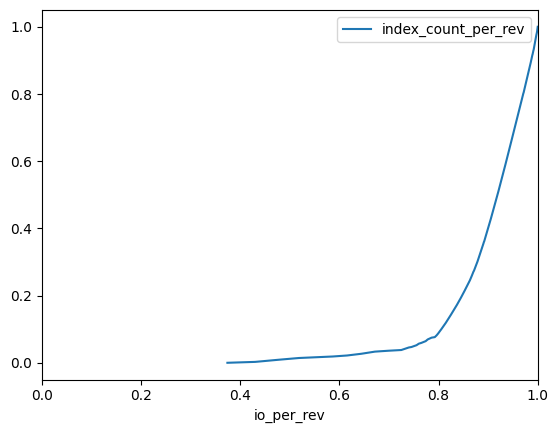

time: 229 ms (started: 2023-09-22 12:53:48 -07:00)


In [10]:
ax = time_range_group_view2.plot(x='io_per_rev', y='index_count_per_rev')
ax.set_xlim(1, 1)
ax

In [15]:
res.views['duration'][('time_range',)].compute()

duration_sum  \
time_range file_name                                          proc_name                                         
1          /dev/null                                          app1#localhost#17#35184372411024       0.000003   
           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3          /dev/null                                          app1#localhost#1#35184372411024        0.000003   
                                                              app1#localhost#10#35184372411024       0.000002   
                                                              app1#localhost#100#35184372411024      0.000003   
...                                                                                                       ...   
669        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024      0.000005   
                                                              app1#localhost#880#35184372411024      0.000005   
                                                              app1#localhost#920#35184372411024      0.000005   
                                                              app1#localhost#960#35184372411024      0.000005   
           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000226   

                                                                                                 index_count  \
time_range file_name                                          proc_name                                        
1          /dev/null                                          app1#localhost#17#35184372411024             1   
           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3          /dev/null                                          app1#localhost#1#35184372411024              1   
                                                              app1#localhost#10#35184372411024             1   
                                                              app1#localhost#100#35184372411024            1   
...                                                                                                      ...   
669        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024            1   
                                                              app1#localhost#880#35184372411024            1   
                                                              app1#localhost#920#35184372411024            1   
                                                              app1#localhost#960#35184372411024            1   
           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              2   

                                                                                                 size_min  \
time_range file_name                                          proc_name                                     
1          /dev/null                                          app1#localhost#17#35184372411024          0   
           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3          /dev/null                                          app1#localhost#1#35184372411024           0   
                                                              app1#localhost#10#35184372411024          0   
                                                              app1#localhost#100#35184372411024         0   
...                                                                                                   ...   
669        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024         0   
                                                              app1#localhost#880#35184372411024         0   
                                                              app1#localhost#920

time: 200 ms (started: 2023-09-22 11:02:17 -07:00)


In [7]:
res.bottlenecks['duration'][('proc_name',)]['mid_level_view']['duration_th'].value_counts().compute()

0.000    619
0.010    198
0.001    128
0.500     19
0.250     13
Name: duration_th, dtype: int64

time: 260 ms (started: 2023-08-03 20:33:53 -07:00)


In [ ]:
res.bottlenecks['bw'][('proc_name',)]['mid_level_view']['bw_th'].value_counts().compute()

In [ ]:
res.bottlenecks['iops'][('proc_name',)]['mid_level_view']['iops_th'].value_counts().compute()

In [10]:
dur_proc_ml = res.bottlenecks['duration'][('proc_name',)]['mid_level_view'].compute()
dur_proc_ml.query('duration_th >= 0.5')[['duration_sum', 'metadata_time', 'open_time', 'close_time', 'duration_th', 'duration_score']]

,,duration_sum,metadata_time,open_time,close_time,duration_th,duration_score
proc_name,time_range,,,,,,
app1#localhost#1000#35184372411024,5,2.151723,2.151723,2.151723,0.0,0.5,high
app1#localhost#1080#35184372411024,5,2.116145,2.116145,2.116145,0.0,0.5,high
app1#localhost#1120#35184372411024,5,2.116290,2.116290,2.116290,0.0,0.5,high
app1#localhost#120#35184372411024,5,2.129455,2.129455,2.129455,0.0,0.5,high
app1#localhost#1240#35184372411024,5,2.151049,2.151049,2.151049,0.0,0.5,high
app1#localhost#160#35184372411024,5,2.069059,2.069059,2.069059,0.0,0.5,high
app1#localhost#200#35184372411024,5,2.151693,2.151693,2.151693,0.0,0.5,high
app1#localhost#280#35184372411024,5,2.139112,2.139112,2.139112,0.0,0.5,high
app1#localhost#360#35184372411024,5,2.165936,2.165936,2.165936,0.0,0.5,high


time: 261 ms (started: 2023-08-03 20:33:54 -07:00)


In [11]:
dur_proc_ll = res.bottlenecks['duration'][('proc_name',)]['low_level_view'].compute()
dur_proc_ll.query('duration_th >= 0.5')[['duration_sum', 'metadata_time', 'open_time', 'close_time', 'duration_th', 'duration_score']]

,,,duration_sum,metadata_time,open_time,close_time,duration_th,duration_score
proc_name,time_range,file_name,,,,,,
app1#localhost#1000#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.151723,2.151723,2.151723,0.0,0.5,high
app1#localhost#1080#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.116145,2.116145,2.116145,0.0,0.5,high
app1#localhost#1120#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.116290,2.116290,2.116290,0.0,0.5,high
app1#localhost#120#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.129455,2.129455,2.129455,0.0,0.5,high
app1#localhost#1240#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.151049,2.151049,2.151049,0.0,0.5,high
app1#localhost#160#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.069059,2.069059,2.069059,0.0,0.5,high
app1#localhost#200#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.151693,2.151693,2.151693,0.0,0.5,high
app1#localhost#280#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.139112,2.139112,2.139112,0.0,0.5,high
app1#localhost#360#35184372411024,5,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.165936,2.165936,2.165936,0.0,0.5,high


time: 196 ms (started: 2023-08-03 20:33:54 -07:00)


In [12]:
iops_proc_ll = res.bottlenecks['iops'][('proc_name',)]['low_level_view'].compute()
iops_proc_ll.query('iops_th >= 0.75')[['duration_sum', 'iops', 'data_count', 'size_sum', 'metadata_count', 'open_count', 'open_time', 'close_count', 'close_time', 'seek_count', 'write_count', 'write_time', 'stat_time', 'iops_score']]

duration_sum  \
proc_name                       time_range file_name                                                          
app1#localhost#0#35184372411024 6          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003493   
                                7          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003301   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.029512   
                                60         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.023064   
                                128        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.010099   
                                129        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003359   
                                135        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.005574   
                                138        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004952   
                                149        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003986   
                                185        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.031704   
                                197        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003988   
                                199        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.021971   
                                218        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004139   
                                231        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004131   
                                233        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.014110   
                                234        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003583   
                                272        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003691   
                                340        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003736   
                                344        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.015173   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.006550   
                                345        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003395   
                                347        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004066   
                                361        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.029139   
                                378        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004194   
                                401        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003357   
                                408        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.024926   
                                450        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003986   
                                454        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.019950   
                                475        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004301   
                                503        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003980   
                                549        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003443   
                                556        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004059   
                                561        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.011695   
                                571        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.004489   
                                576        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      

time: 209 ms (started: 2023-08-03 20:33:55 -07:00)


In [13]:
bw_proc_ll = res.bottlenecks['bw'][('proc_name',)]['low_level_view'].compute()
bw_proc_ll.query('bw_th >= 0.75')[['duration_sum', 'bw', 'data_count', 'size_sum', 'metadata_count', 'open_count', 'open_time', 'close_count', 'close_time', 'seek_count', 'write_count', 'write_time', 'stat_time', 'bw_score']]

duration_sum  \
proc_name                       time_range file_name                                                          
app1#localhost#0#35184372411024 4          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002457   
                                6          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000814   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000571   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003493   
                                7          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.029512   
...                                                                                                     ...   
                                652        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002536   
                                654        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000974   
                                667        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000179   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000061   
                                668        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.001697   

                                                                                                         bw  \
proc_name                       time_range file_name                                                          
app1#localhost#0#35184372411024 4          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  8.363858e+05   
                                6          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  7.897323e+05   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  3.502627e+04   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  7.787671e+04   
                                7          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  2.327835e+05   
...                                                                                                     ...   
                                652        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  2.180341e+06   
                                654        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  5.676452e+06   
                                667        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  3.590173e+06   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  2.306425e+06   
                                668        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  4.048321e+06   

                                                                                               data_count  \
proc_name                       time_range file_name                                                        
app1#localhost#0#35184372411024 4          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                6          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                           /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                7          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
...                                                                                                   ...   
                                652        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                654        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
                                667        /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...           1   
        

time: 208 ms (started: 2023-08-03 20:33:55 -07:00)


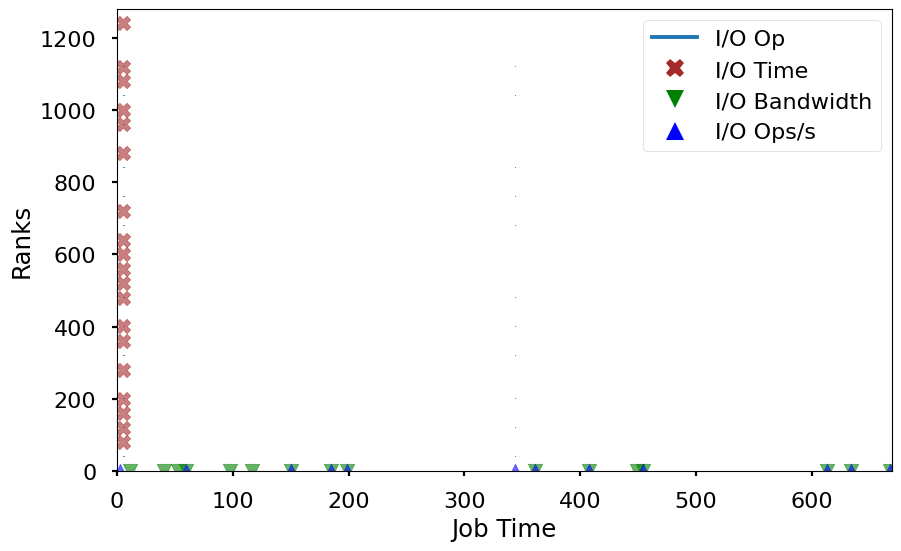

time: 2.96 s (started: 2023-08-02 18:59:40 -07:00)


In [200]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')
# plt.figure(figsize=(8, 4))

fig, ax, bar_data, scatter_data = res.plot.bottleneck_bar(
    figsize=(10, 6),
    metrics=['duration', 'bw', 'iops'],
    labels=['I/O Time', 'I/O Bandwidth', 'I/O Ops/s'],
    thresholds=[0.5, 0.75, 0.75],
    markers=['X', 'v', '^'],
    colors=['brown', 'green', 'blue'],
    marker_size=108,
)

# ax.annotate('''a) Every first rank per node 
# "open"ing the same config file 
# simultaneously causes 
# bottlenecks per I/O time''',
#     xy=(15, 720), 
#     xytext=(16, 32),
#     arrowprops=dict(
#         arrowstyle="wedge,tail_width=2.",
#         fc=(1.0, 0.7, 0.7), 
#         ec="none",
#         patchA=None
#     ),
#     bbox=dict(
#         boxstyle="round", 
#         fc=(1.0, 0.7, 0.7), 
#         ec="none"
#     ),
#     # color='white',
#     size=18,
#     textcoords='offset points',
# )

# ax.annotate('''b) Simulation data writes 
# dominated by metadata 
# operations (>80%) causes 
# bottlenecks per I/O BW''',
#     xy=(100, 28), 
#     xytext=(-48, 32),
#     arrowprops=dict(
#         arrowstyle="wedge,tail_width=2.",
#         fc=(1.0, 0.7, 0.7), 
#         ec="none",
#         patchA=None
#     ),
#     bbox=dict(
#         boxstyle="round", 
#         fc=(1.0, 0.7, 0.7), 
#         ec="none"
#     ),
#     # color='white',
#     # ha='center',
#     size=18,
#     textcoords='offset points',
# )

# ax.annotate('''c) Simulation data writes 
# dominated by small writes
# causes bottlenecks per 
# both I/O BW and I/O ops/s''',
#     xy=(634, 28), 
#     xytext=(-220, 48),
#     arrowprops=dict(
#         arrowstyle="wedge,tail_width=2.",
#         fc=(1.0, 0.7, 0.7), 
#         ec="none",
#         patchA=None
#     ),
#     bbox=dict(
#         boxstyle="round", 
#         fc=(1.0, 0.7, 0.7), 
#         ec="none"
#     ),
#     # color='white',
#     # ha='right',
#     size=18,
#     textcoords='offset points',
# )


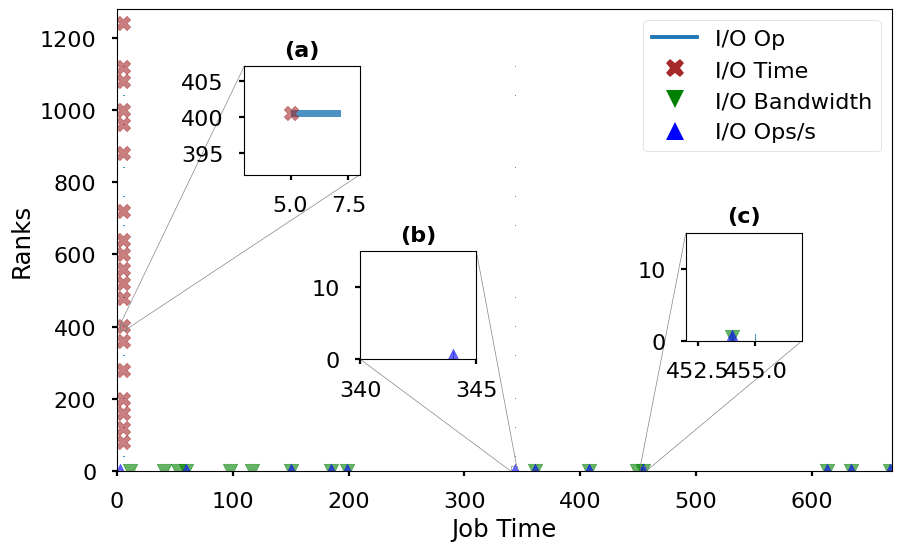

time: 1.52 s (started: 2023-08-02 18:59:43 -07:00)


In [201]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def mark_zoom(ax, zoom, bbox_to_anchor, xlim, ylim, loc1, loc2, note):
    axins = zoomed_inset_axes(ax, zoom, loc='upper left', bbox_to_anchor=bbox_to_anchor, bbox_transform=ax.transAxes)

    for b in bar_data:
        axins.broken_barh(**b)

    for metric, s0 in scatter_data.items():
        for s in s0:
            axins.scatter(**s)

    axins.set_xlim(xlim)
    axins.set_ylim(ylim)

    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.5")

    axins.annotate(note, xy=(0.5, 1.15), xycoords='axes fraction',
                ha='center', va='center', fontsize=16, weight='bold')

mark_zoom(
    ax=ax,
    zoom=20,
    bbox_to_anchor=(0.15, 0.6, .3, .3),
    xlim=(3, 8),
    ylim=(392, 407),
    loc1=2,
    loc2=4,
    note='(a)'
)

mark_zoom(
    ax=ax,
    zoom=20,
    bbox_to_anchor=(0.3, 0.2, .3, .3),
    xlim=(340, 345),
    ylim=(0, 15),
    loc1=1,
    loc2=3,
    note='(b)'
)

mark_zoom(
    ax=ax,
    zoom=20,
    bbox_to_anchor=(0.72, 0.24, .3, .3),
    xlim=(452, 457),
    ylim=(0, 15),
    loc1=2,
    loc2=4,
    note='(c)'
)

fig

In [202]:
fig.savefig('cm1.pdf', bbox_inches='tight')

time: 1.29 s (started: 2023-08-02 19:00:06 -07:00)


In [10]:
bot_dur_proc_ml = res.bottlenecks['duration'][('proc_name',)]['mid_level_view'].compute()
bot_iops_proc_ml = res.bottlenecks['iops'][('proc_name',)]['mid_level_view'].compute()
bot_bw_proc_ml = res.bottlenecks['bw'][('proc_name',)]['mid_level_view'].compute()

time: 825 ms (started: 2023-07-31 15:31:58 -07:00)


In [24]:
bot_bw_proc_ml['bw_th'].value_counts()

0.001    1219
0.500     357
0.100      23
0.010      20
0.750      17
0.900       3
0.250       1
Name: bw_th, dtype: int64

time: 5.48 ms (started: 2023-07-31 15:39:13 -07:00)


In [26]:
bot_bw_proc_ml.query('bw_th > 0.4')

duration_sum  index_count  \
proc_name                       time_range                              
app1#localhost#0#35184372411024 5               1.970968            1   
                                9               0.003103           40   
                                11              0.002862           22   
                                12              0.000628           18   
                                22              0.004685           40   
...                                                  ...          ...   
                                660             0.001810           40   
                                662             0.001751           40   
                                664             0.001761           40   
                                666             0.001675           40   
                                667             0.027776           32   

                                            size_min  size_max  size_sum  \
proc_name                       time_range                                 
app1#localhost#0#35184372411024 5                  0         0         0   
                                9                544     49340    130527   
                                11                 0      5530      6346   
                                12             13785     49340    124453   
                                22              1088     49340    131071   
...                                              ...       ...       ...   
                                660             5530     97104    227087   
                                662             5530     97376    227359   
                                664             5530     97648    227631   
                                666             5530     97920    227903   
                                667                0     98192    104505   

                                            read_time  write_time  \
proc_name                       time_range                          
app1#localhost#0#35184372411024 5                 0.0    0.000000   
                                9                 0.0    0.000421   
                                11                0.0    0.000114   
                                12                0.0    0.000273   
                                22                0.0    0.000848   
...                                               ...         ...   
                                660               0.0    0.000394   
                                662               0.0    0.000380   
                                664               0.0    0.000411   
                                666               0.0    0.000377   
                                667               0.0    0.000191   

                                            metadata_time  read_size  \
proc_name                       time_range                             
app1#localhost#0#35184372411024 5                1.970968          0   
                                9                0.002682          0   
                                11               0.002748          0   
                                12               0.000355          0   
                                22               0.003837          0   
...                                                   ...        ...   
                                660              0.001416          0   
                                662              0.001371          0   
                                664              0.001350          0   
                                666              0.001298          0   
                                667              0.027585          0   

                                            write_size  ...            bw  \
proc_name                       time_range              ...                 
app1#localhost#0#35184372411024 5                    0  ...  0.000000e+00   
                                9      

time: 46.8 ms (started: 2023-07-31 15:40:39 -07:00)


In [23]:
bot_iops_proc_ml['iops_th'].value_counts()

0.001    947
0.500    388
0.000    235
0.010    210
0.900    203
0.250    117
0.750     68
0.100     29
Name: iops_th, dtype: int64

time: 5.16 ms (started: 2023-07-31 15:39:00 -07:00)


In [25]:
bot_dur_proc_ml.query('duration_th > 0.4')

,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,bw,iops,intensity,id,att_perf,duration_norm,duration_pero,duration_perr,duration_score,duration_th
proc_name,time_range,,,,,,,,,,,,,,,,,,,,,
app1#localhost#1000#35184372411024,5,2.151723,1,0,0,0,0.0,0.0,2.151723,0,0,...,0.0,0.464744,0.0,6.065609e+18,0.0,0.522885,0.522885,0.022172,high,0.5
app1#localhost#1080#35184372411024,5,2.116145,1,0,0,0,0.0,0.0,2.116145,0,0,...,0.0,0.472557,0.0,-5.437124e+18,0.0,0.514239,0.514239,0.021806,high,0.5
app1#localhost#1120#35184372411024,5,2.116290,1,0,0,0,0.0,0.0,2.116290,0,0,...,0.0,0.472525,0.0,8.200516e+18,0.0,0.514274,0.514274,0.021807,high,0.5
app1#localhost#120#35184372411024,5,2.129455,1,0,0,0,0.0,0.0,2.129455,0,0,...,0.0,0.469604,0.0,1.967050e+17,0.0,0.517473,0.517473,0.021943,high,0.5
app1#localhost#1240#35184372411024,5,2.151049,1,0,0,0,0.0,0.0,2.151049,0,0,...,0.0,0.464889,0.0,8.488019e+18,0.0,0.522721,0.522721,0.022165,high,0.5
app1#localhost#160#35184372411024,5,2.069059,1,0,0,0,0.0,0.0,2.069059,0,0,...,0.0,0.483312,0.0,5.743701e+18,0.0,0.502797,0.502797,0.021321,high,0.5
app1#localhost#200#35184372411024,5,2.151693,1,0,0,0,0.0,0.0,2.151693,0,0,...,0.0,0.464750,0.0,-7.789331e+18,0.0,0.522877,0.522877,0.022172,high,0.5
app1#localhost#280#35184372411024,5,2.139112,1,0,0,0,0.0,0.0,2.139112,0,0,...,0.0,0.467484,0.0,-2.926339e+18,0.0,0.519820,0.519820,0.022042,high,0.5
app1#localhost#360#35184372411024,5,2.165936,1,0,0,0,0.0,0.0,2.165936,0,0,...,0.0,0.461694,0.0,-2.827899e+18,0.0,0.526339,0.526339,0.022319,high,0.5


time: 52.6 ms (started: 2023-07-31 15:39:32 -07:00)


In [22]:
bot_dur_proc_ml['duration_th'].value_counts()

0.000    619
0.010    198
0.001    128
0.500     19
0.250     13
Name: duration_th, dtype: int64

time: 5.69 ms (started: 2023-07-31 15:38:38 -07:00)


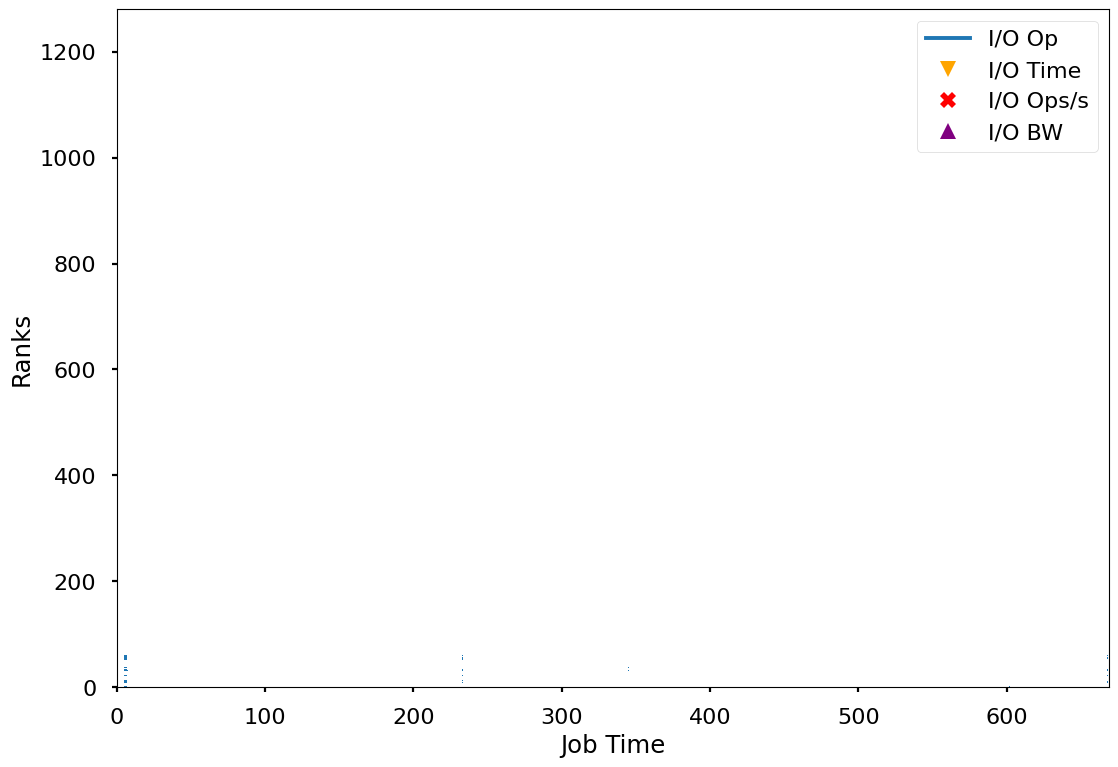

time: 540 ms (started: 2023-07-31 15:37:08 -07:00)


In [19]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

fig, ax = plt.subplots()

cmap = plt.cm.RdYlGn
norm = plt.Normalize(vmin=0, vmax=1)

LIMIT = 1280

proc_names = list(bot_dur_proc_ml.index.get_level_values(0).unique())

for i, ix in enumerate(proc_names):
    # colors = list(map(_color_map, bot_dur_proc_ml.loc[ix]['duration_th'].to_dict().items()))
    # ax.broken_barh(bot_dur_proc_ml.loc[ix]['duration_sum'].to_dict().items(), (i, 1), alpha=0.6, facecolors=colors)
    ax.broken_barh(bot_dur_proc_ml.loc[ix]['duration_sum'].to_dict().items(), (i, 1), facecolors='C0')
    if i == LIMIT - 1:
        break

# proc_names = list(bot_bw_proc_ml.index.get_level_values(0).unique())

# for i, ix in enumerate(proc_names):
#     colors = list(map(_color_map, bot_bw_proc_ml.loc[ix]['bw_th'].to_dict().items()))
#     ax.broken_barh(bot_bw_proc_ml.loc[ix]['duration_sum'].to_dict().items(), (i, 1), alpha=0.6, facecolors=colors)
#     if i == 99:
#         break


# for i, ix in enumerate(proc_names):
#     b = 0
#     try:
#         for j, (time_range, th) in enumerate(bot_bw_proc_ml.loc[ix]['bw_th'].head(10).to_dict().items()):
#             if time_range < 6:
#                 continue
#             if th >= 0.9:
#                 ax.scatter(time_range, i + 0.5, marker='^', color='purple')
#                 b += 1
#             # if b > 1:
#             #     break
#         if i == LIMIT - 1:
#             break
#     except:
#         pass

# for i, ix in enumerate(proc_names):
#     b = 0
#     try:
#         for j, (time_range, th) in enumerate(bot_iops_proc_ml.loc[ix]['iops_th'].to_dict().items()):
#             # print(time_range, th)
#             if th >= 0.7:
#                 ax.scatter(time_range, i + 0.5, marker='x', color='red')
#                 b += 1
#             # if b > 1:
#             #     break
#         if i == LIMIT - 1:
#             break
#     except:
#         pass

for i, ix in enumerate(proc_names):
    b = 0
    try:
        for j, (time_range, th) in enumerate(bot_dur_proc_ml.loc[ix]['duration_th'].to_dict().items()):
            if th >= 0.9:
                ax.scatter(time_range, i + 0.5, marker='v', color='orange')
                b += 1
            # if b > 1:
            #     break
        if i == LIMIT - 1:
            break
    except:
        pass

# for i, ((rank, time_range), th) in enumerate(bot_bw_proc_ml['bw_th'].sample(n=20).to_dict().items()):
#     # print(time_range)
#     if th > 0.8:
#         ax.scatter(time_range + 3, proc_names.index(rank), marker='x', color='red')
#     # print('rank', rank, proc_names.index(rank))
#     # ax.scatter(time_range, proc_names.index(rank), marker='x', color='red')
#     if i == 99:
#         break

# for i, ((rank, time_range), th) in enumerate(bot_iops_proc_ml['iops_th'].sample(n=20).to_dict().items()):
#     # print(time_range)
#     if th > 0.8:
#         ax.scatter(time_range + 3, proc_names.index(rank), marker='x', color='red')
#     # print('rank', rank, proc_names.index(rank))
#     # ax.scatter(time_range, proc_names.index(rank), marker='v', color='orange')
#     if i == 99:
#         break

# Step 3: Add markers using scatter plot
# for pos in marker_positions:
#     ax.scatter(pos, 0.5, marker='o', color='red')
# ax.scatter(bot_bw_proc_ml.loc[ix]['duration_sum'].to_dict().items())
# bot_bw_proc_ml.reset_index().plot.scatter(ax=ax, x='duration_sum', y='proc_name', marker='x')
# ax.scatter()

# for i, ix in enumerate(bot_iops_proc_ml.index.get_level_values(0).unique()):
#     colors = list(map(_color_map, bot_iops_proc_ml.loc[ix]['iops_th'].to_dict().items()))
#     ax.broken_barh(bot_iops_proc_ml.loc[ix]['duration_sum'].to_dict().items(), (i, 1), alpha=0.6, cmap=plt.cm.RdYlGn, facecolors=colors)

ax.set_ylim(0, LIMIT)  # len(bot_dur_proc_ml.index.get_level_values(0).unique()))
ax.set_xlim(0, max(bot_dur_proc_ml.index.get_level_values(1)))
ax.set_ylabel('Ranks')
ax.set_xlabel('Job Time')

legend_handles = [
    Line2D([0], [0], color='C0', label='I/O Op'),
    Line2D([0], [0], color='w', label='I/O Time', marker='v', markerfacecolor='orange'),
    Line2D([0], [0], color='w', label='I/O Ops/s', marker='X', markerfacecolor='red'),
    Line2D([0], [0], color='w', label='I/O BW', marker='^', markerfacecolor='purple'),
]

plt.legend(handles=legend_handles, loc='upper right')

plt.show()

(<Figure size 500x500 with 1 Axes>, <Axes: >)

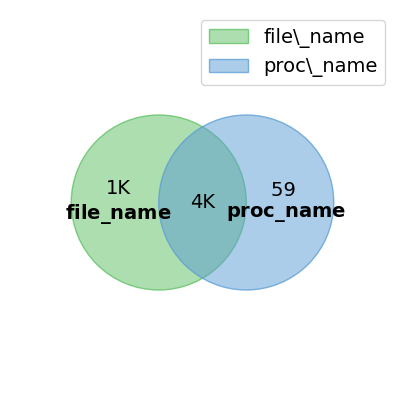

time: 798 ms (started: 2023-07-30 09:18:56 -07:00)


In [7]:
res.plot.view_relations2('duration', ('file_name',), ('proc_name',))

(<Figure size 500x500 with 1 Axes>, <Axes: >)

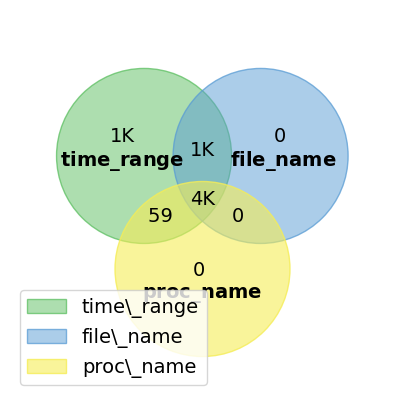

time: 660 ms (started: 2023-07-30 09:18:56 -07:00)


In [8]:
res.plot.view_relations3('duration', ('time_range',), ('file_name',), ('proc_name',))

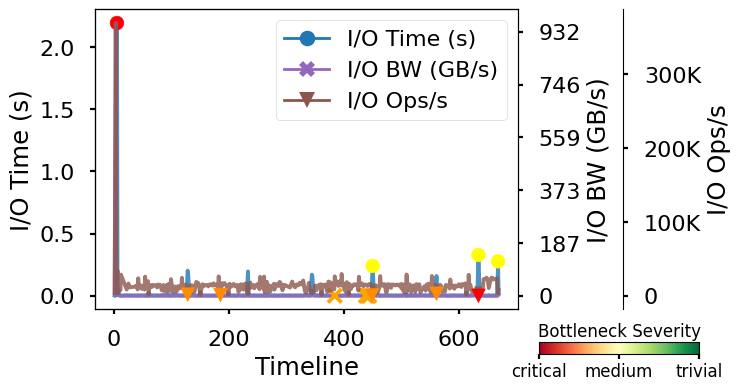

time: 1.78 s (started: 2023-07-30 09:26:50 -07:00)


In [12]:
fig = res.plot.bottleneck_timeline3(
    metric1='duration', 
    metric2='bw', 
    metric3='iops', 
    label1='I/O Time (s)',
    label2='I/O BW (GB/s)',
    label3='I/O Ops/s',
    figsize=(8, 4),
    threshold=0.1,
    sample_count=5,    
)

In [10]:
fig.savefig('cm1.pdf', bbox_inches='tight')

time: 770 ms (started: 2023-07-30 09:19:08 -07:00)


<Axes: title={'center': 'duration'}, xlabel='time_range', ylabel='duration_sum'>

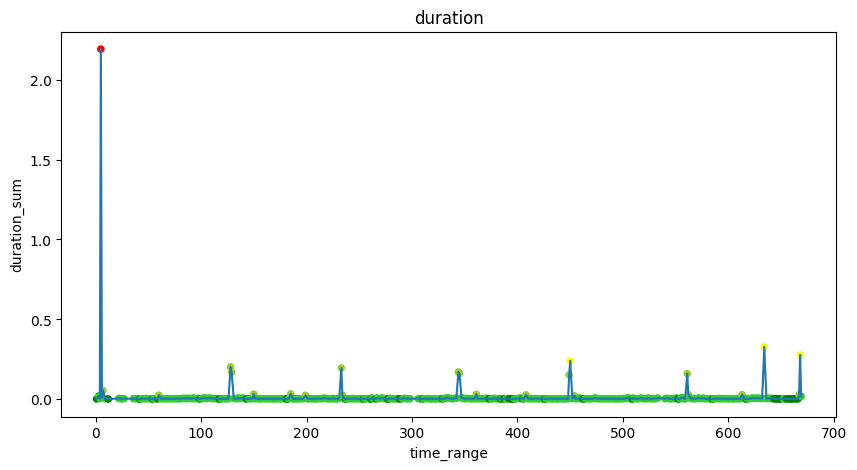

time: 715 ms (started: 2023-07-29 10:12:10 -07:00)


In [31]:
res.plot.bottleneck_timeline('duration')

<Axes: title={'center': 'bw'}, xlabel='time_range', ylabel='bw'>

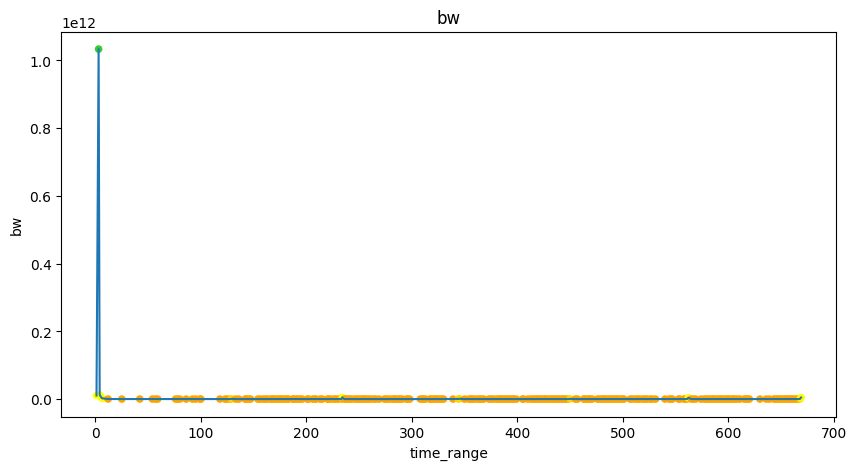

time: 710 ms (started: 2023-07-29 10:12:16 -07:00)


In [32]:
res.plot.bottleneck_timeline('bw')

<Axes: title={'center': 'iops'}, xlabel='time_range', ylabel='iops'>

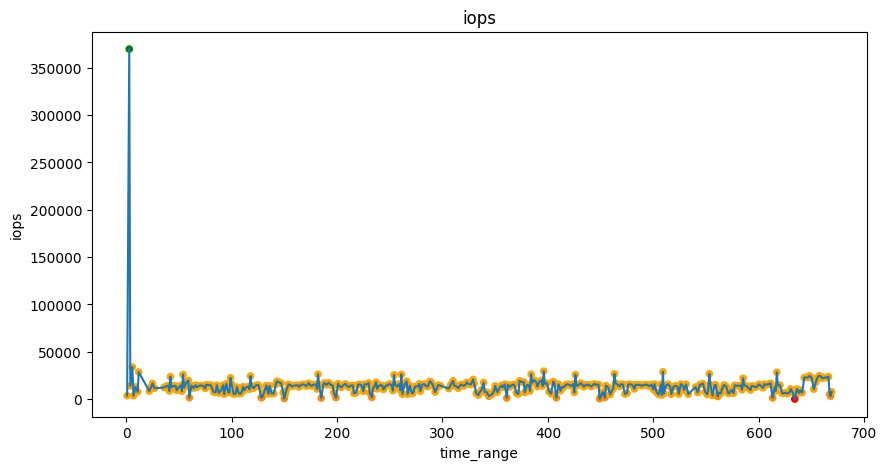

time: 760 ms (started: 2023-07-29 10:12:19 -07:00)


In [33]:
res.plot.bottleneck_timeline('iops')

In [7]:
main_view, views, bottlenecks = res

time: 837 µs (started: 2023-07-28 18:56:09 -07:00)


In [8]:
main_view.head(10)

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024        0.001609   
3      /dev/null                                          app1#localhost#1#35184372411024         0.000003   
                                                          app1#localhost#10#35184372411024        0.000002   
                                                          app1#localhost#100#35184372411024       0.000003   
                                                          app1#localhost#1000#35184372411024      0.000003   
                                                          app1#localhost#1001#35184372411024      0.000003   
                                                          app1#localhost#1002#35184372411024      0.000003   
                                                          app1#localhost#1003#35184372411024      0.000003   
                                                          app1#localhost#1004#35184372411024      0.000002   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024              5   
3      /dev/null                                          app1#localhost#1#35184372411024               1   
                                                          app1#localhost#10#35184372411024              1   
                                                          app1#localhost#100#35184372411024             1   
                                                          app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1001#35184372411024            1   
                                                          app1#localhost#1002#35184372411024            1   
                                                          app1#localhost#1003#35184372411024            1   
                                                          app1#localhost#1004#35184372411024            1   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024    16777216   
3      /dev/null                                          app1#localhost#1#35184372411024            0   
                                                          app1#localhost#10#35184372411024           0   
                                                          app1#localhost#100#35184372411024          0   
                                                          app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1001#35184372411024         0   
                                                          app1#localhost#1002#35184372411024         0   
                                                          app1#localhost#1003#35184372411024         0   
                                                          app1#localhost#1004#35184372411024         0   

                                                                                              size_max  \
trange file_name                                          proc_name                  

time: 70.1 ms (started: 2023-07-28 18:56:09 -07:00)


In [9]:
views['duration_sum'][('trange',)].compute()

duration_sum  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024       0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3      /dev/null                                          app1#localhost#1#35184372411024        0.000003   
                                                          app1#localhost#10#35184372411024       0.000002   
                                                          app1#localhost#100#35184372411024      0.000003   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024      0.000005   
                                                          app1#localhost#880#35184372411024      0.000005   
                                                          app1#localhost#920#35184372411024      0.000005   
                                                          app1#localhost#960#35184372411024      0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000226   

                                                                                             index_count  \
trange file_name                                          proc_name                                        
1      /dev/null                                          app1#localhost#17#35184372411024             1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3      /dev/null                                          app1#localhost#1#35184372411024              1   
                                                          app1#localhost#10#35184372411024             1   
                                                          app1#localhost#100#35184372411024            1   
...                                                                                                  ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024            1   
                                                          app1#localhost#880#35184372411024            1   
                                                          app1#localhost#920#35184372411024            1   
                                                          app1#localhost#960#35184372411024            1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              2   

                                                                                             size_min  \
trange file_name                                          proc_name                                     
1      /dev/null                                          app1#localhost#17#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /dev/null                                          app1#localhost#1#35184372411024           0   
                                                          app1#localhost#10#35184372411024          0   
                                                          app1#localhost#100#35184372411024         0   
...                                                                                               ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024         0   
                                                          app1#localhost#880#35184372411024         0   
                                                          app1#localhost#920#35184372411024         0   
                                                          app1#localhost#960#35184372411024         0   
       /p/

time: 228 ms (started: 2023-07-28 18:56:10 -07:00)


In [10]:
bottlenecks['duration_sum'][('trange',)]['high_level_view'].compute()

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,att_perf,duration_pero,duration_perr,duration_score,duration_th
trange,,,,,,,,,,,,,,,,,,,,,
1,0.001612,6,0,16777216,16777216,0.001470,0.000000,0.000142,16777216,0,...,0,3,1.040899e+10,3722.546191,3.576279e-07,6.803647e+02,0.000735,0.000275,none,0.000
3,0.020756,7673,0,16777216,21441282048,0.001981,0.000000,0.020747,21441282048,0,...,1,3836,1.033036e+12,369683.347498,3.578611e-07,1.953726e+09,0.009469,0.003545,trivial,0.001
4,0.004128,58,0,16777216,50456557,0.001317,0.000201,0.002610,50331648,124909,...,1,42,1.222448e+10,14052.089326,1.149504e-06,1.357908e+07,0.001883,0.000705,trivial,0.001
5,2.191843,32,0,0,0,0.000000,0.000000,2.191843,0,0,...,0,0,0.000000e+00,14.599587,0.000000e+00,0.000000e+00,1.000000,0.374355,critical,0.900
6,0.011320,384,0,16777216,33560897,0.000000,0.006047,0.005273,0,33560897,...,2,270,2.964770e+09,33922.561157,1.144189e-05,8.985663e+07,0.005165,0.001933,trivial,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.001761,40,5530,97648,227631,0.000000,0.000411,0.001350,0,130255,...,5,14,1.292477e+08,22711.787246,1.757230e-04,7.917566e+06,0.000804,0.000301,none,0.000
666,0.001675,40,5530,97920,227903,0.000000,0.000377,0.001298,0,130255,...,5,14,1.360777e+08,23883.448781,1.755133e-04,8.079364e+06,0.000764,0.000286,none,0.000
667,0.027776,142,0,98192,104505,0.000000,0.000191,0.027585,0,6465,...,6,90,3.762461e+06,5112.382342,1.358787e-03,3.039387e+07,0.012672,0.004744,very low,0.010


time: 376 ms (started: 2023-07-28 18:56:11 -07:00)


In [11]:
dur_trange_bot_ll = bottlenecks['duration_sum'][('trange',)]['low_level_view'].query('duration_th > 0').compute()
dur_trange_bot_ll

duration_sum  \
trange proc_name                          file_name                                                          
3      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.020722   
4      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002457   
5      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      1.970968   
       app1#localhost#1000#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2.151723   
       app1#localhost#1040#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      1.952563   
...                                                                                                    ...   
668    app1#localhost#960#35184372411024  /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.117417   
669    app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.008169   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002690   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002363   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.003665   

                                                                                              index_count  \
trange proc_name                          file_name                                                         
3      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            6   
4      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            8   
5      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
       app1#localhost#1000#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
       app1#localhost#1040#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
...                                                                                                   ...   
668    app1#localhost#960#35184372411024  /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            4   
669    app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            4   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            2   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            2   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            3   

                                                                                              size_min  \
trange proc_name                          file_name                                                      
3      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
4      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2055   
5      app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
       app1#localhost#1000#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
       app1#localhost#1040#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
...                                                                                                ...   
668    app1#localhost#960#35184372411024  /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
669    app1#localhost#0#35184372411024    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  13369344   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...   8454144   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/c

time: 274 ms (started: 2023-07-28 18:56:11 -07:00)


In [12]:
from wisio.rules import Rule
from wisio._recorder.rules import RecorderRuleEngine

    # app_name=('app_name', 'trange', 'file_name'),
    # file_dir=('file_dir', 'proc_name', 'trange'),
    # file_name=('file_name', 'proc_name', 'trange'),
    # file_regex=('file_regex', 'proc_name', 'trange'),
    # node_name=('node_name', 'trange', 'file_name'),
    # proc_name=('proc_name', 'trange', 'file_name'),
    # rank=('rank', 'trange', 'file_name'),
    # trange=('trange', 'proc_name', 'file_name'),

rules = dict(
    app_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    file_dir=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    file_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    file_regex=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    node_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    proc_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    rank=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    trange=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
)

rule_engine = RecorderRuleEngine(rules=rules)

rule_engine


time: 14.8 ms (started: 2023-07-28 19:00:35 -07:00)


In [13]:
%autoreload 2

characteristics = rule_engine.process_characteristics(view=main_view)
characteristics


{<Rule.CHAR_IO_TIME: 118>: RuleResult(data_dict=None, description='I/O Time', detail_list=['Read - 0.00 seconds (0.05%)', 'Write - 0.58 seconds (14.08%)', 'Metadata - 3.53 seconds (85.89%)'], reasons=None, rule=<Rule.CHAR_IO_TIME: 118>, value=4.1151000122494, value_fmt='4.12 seconds'),
 <Rule.CHAR_IO_COUNT: 111>: RuleResult(data_dict=None, description='I/O Ops', detail_list=['Read - 1,282 ops (4.67%)', 'Write - 2,303 ops (8.39%)', 'Metadata - 23,878 ops (86.95%)'], reasons=None, rule=<Rule.CHAR_IO_COUNT: 111>, value=27463, value_fmt='27,463 ops'),
 <Rule.CHAR_IO_SIZE: 116>: RuleResult(data_dict=None, description='I/O Size', detail_list=['Read - 20.03 GB (94.51%)', 'Write - 1.15 GB (5.41%)'], reasons=None, rule=<Rule.CHAR_IO_SIZE: 116>, value=22756918836, value_fmt='21.19 GB'),
 <Rule.CHAR_READ_XFER_SIZE: 132>: RuleResult(data_dict=None, description='Read Xfer', detail_list=['4-16 MB - 1,282 ops (100.00%)'], reasons=None, rule=<Rule.CHAR_READ_XFER_SIZE: 132>, value=(16777216, 16777216),

time: 210 ms (started: 2023-07-28 19:00:35 -07:00)


In [14]:
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.tree import Tree

# Create a new Table object from Rich library
table = Table(box=None, show_header=False)

# Add columns to the table for the key and value
table.add_column(style="cyan")
table.add_column()

# Add each key-value pair to the table as a row
for rule, result in characteristics.items():
    if result.detail_list is None:
        table.add_row(result.description, result.value_fmt)
    else:
        detail_tree = Tree(result.value_fmt)
        for detail in result.detail_list:
            detail_tree.add(detail)
        table.add_row(result.description, detail_tree)

# Create a Console object from Rich library
console = Console()

# Print the table with Rich formatting
console.print(Panel(table, title='Summary'))


╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  I/O Time        4.12 seconds                                                                                   │
│                  ├── Read - 0.00 seconds (0.05%)                                                                │
│                  ├── Write - 0.58 seconds (14.08%)                                                              │
│                  └── Metadata - 3.53 seconds (85.89%)                                                           │
│  I/O Ops         27,463 ops                                                                                     │
│                  ├── Read - 1,282 ops (4.67%)                                                                   │
│                  ├── Write - 2,303 ops (8.39%)                                                                  │
│                  └── Metadata - 23,878 ops (86.95%)                                                             │
│  I/O Size        21.19 GB                                                                                       │
│                  ├── Read - 20.03 GB (94.51%)                                                                   │
│                  └── Write - 1.15 GB (5.41%)                                                                    │
│  Read Xfer       16 MB - 1,282 ops                                                                              │
│                  └── 4-16 MB - 1,282 ops (100.00%)                                                              │
│  Write Xfer      4 KB-16 MB - 2,254 ops                                                                         │
│                  ├── <4 KB - 397 ops (17.61%)                                                                   │
│                  ├── 4-16 KB - 1,092 ops (48.45%)                                                               │
│                  ├── 16-64 KB - 722 ops (32.03%)                                                                │
│                  ├── 64-256 KB - 1 ops (0.04%)                                                                  │
│                  └── 4-16 MB - 42 ops (1.86%)                                                                   │
│  Apps            1 apps                                                                                         │
│                  └── app1 - 4.12 s (100.00%) - 20.03/1.15 GB R/W (94.51/5.41%) - 27,463 ops (100.00%)           │
│  Nodes           1 nodes                                                                                        │
│                  └── localhost - 4.12 s (100.00%) - 20.03/1.15 GB R/W (94.51/5.41%) - 27,463 ops (100.00%)      │
│  Files           775 files                                                                                      │
│                  ├── Shared: 775 files (100.00%)                                                                │
│                  └── FPP: 0 files (0.00%)                                                                       │
│  Access Pattern  100.00% Sequential - 0.00% Random                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

time: 183 ms (started: 2023-07-28 19:00:37 -07:00)


In [15]:
%autoreload 2

processed_bottlenecks = rule_engine.process_bottlenecks(bottlenecks=bottlenecks, characteristics=characteristics, threshold=0.01)
processed_bottlenecks

{'duration_sum': {('trange',): {<Rule.BOTT_METADATA_ACCESS: 207>: {5: RuleResult(data_dict={'llc': {'duration_sum': 2.191842794418335, 'index_count': 32, 'size_min': 0, 'size_max': 0, 'size_sum': 0, 'read_time': 0.0, 'write_time': 0.0, 'metadata_time': 2.191842794418335, 'read_size': 0, 'write_size': 0, 'metadata_size': 0, 'read_count': 0, 'write_count': 0, 'metadata_count': 32, 'read_min': 0, 'read_max': 0, 'write_min': 0, 'write_max': 0, 'metadata_min': 0, 'metadata_max': 0, 'data_count': 0, 'data_size': 0, 'data_time': 0.0, 'sequential_time': 0.0, 'random_time': 0.0, 'sequential_size': 0, 'random_size': 0, 'sequential_count': 0, 'random_count': 0, 'close_time': 0.0, 'open_time': 2.191842794418335, 'seek_time': 0.0, 'stat_time': 0.0, 'close_count': 0, 'open_count': 32, 'seek_count': 0, 'stat_count': 0, 'bw': 0.0, 'iops': 14.599587197352841, 'intensity': 0.0, 'att_perf': 0.0, 'duration_pero': 1.0, 'duration_perr': 0.37435507603975887, 'duration_score': 'critical', 'duration_th': 0.9},

time: 6.94 s (started: 2023-07-28 19:00:38 -07:00)


In [ ]:
from rich.tree import Tree
from rich.console import Console

# create a tree object
tree = Tree("Bottlenecks")

for view_key, bottleneck_dict in processed_bottlenecks.items():
    branch_name = '_'.join(view_key) if isinstance(view_key, tuple) else view_key
    branch = tree.add(branch_name)
    for rule, rule_results in bottleneck_dict.items():
        subbranch = branch.add(rule.name)
        for bottleneck_key, result in rule_results.items():
            subbranch.add(result.description)


# create a console object and print the tree
console = Console()
console.print(tree)


In [18]:
from rich.table import Table
from rich.console import Console

# define the data as a list of tuples
data = [
    ("Root", None),
    ("Branch 1", "Root"),
    ("Leaf 1.1", "Branch 1"),
    ("Leaf 1.2", "Branch 1"),
    ("Branch 2", "Root"),
    ("Leaf 2.1", "Branch 2"),
    ("Leaf 2.2", "Branch 2"),
]

# create a table object and add columns
table = Table(show_header=False, box=None)
table.add_column(justify="left")
table.add_column(justify="left")

# add rows to the table
for row in data:
    if row[1] is None:
        table.add_row(row[0])
    else:
        table.add_row("", row[0])

# print the table
console = Console()
console.print(table)


Root           
       Branch 1 
       Leaf 1.1 
       Leaf 1.2 
       Branch 2 
       Leaf 2.1 
       Leaf 2.2

time: 7.39 ms (started: 2023-03-22 22:09:00 -07:00)


'/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat': 
RuleResult(rule=<Rule.METADATA_ACCESS_ISSUE: 21>, 
           
           description="'/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat' is 
           accessed by 32 process(es) during the 4th second(s) and spent 100.00% (2.19 seconds) of its I/O time on the 
           'open' operation(s).", 
        
    reasons=[RuleReason(description='Metadata time is 100.00% (2.19 seconds) of I/O time', value=1.0)])

- observation: '/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat' is 
           accessed by 32 process(es) during the 4th second(s)
- reason for bottleneck selection: has an I/O time of X which in Y% of overall I/O time of the workload.
- reason1: Overall % of I/O time is spent on metadata access, specifically % on 'open' ... and % on others. 

SMALL_IO_ACCESS

description = (
            f"'{ix}' is accessed by process(es) {join_with_and(processes_fmt)} "
            f"during the {join_with_and(values=trange_intervals)}th second(s) "
            f"with a transfer size smaller than 256KB ({max_xfer_size / 1024:.2f}KB)."
        )

- observation: '{ix}' is accessed by process(es) {join_with_and(processes_fmt)} during the {join_with_and(values=trange_intervals)}th second(s)
- reason for bottleneck: has an I/O time of X which in Y% of overall I/O time of the workload.
- reason1: Average I/O accesses on this file are smaller than 256KB, which is a small data access for GPFS. 
           Specifically ... (histogram or frequency/read or write)
- reason2: If metadata access > 50% ... 
TODO : check whether the file is on GPFS or not

In [15]:
files = ['/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat','/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat']
files

['/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat',
 '/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat']

time: 3.66 ms (started: 2023-03-16 11:49:16 -07:00)


In [16]:
all(['/gpfs' in f for f in files])

True

time: 3.63 ms (started: 2023-03-16 11:49:39 -07:00)


In [16]:
trange_hl_view = bottlenecks[('trange',)]['high_level_view'].compute()
trange_hl_view


,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
trange,,,,,,,,,,,,,,,,,,,,,
1,0.001612,6,0,16777216,16777216,0.001470,0.000000,0.000142,16777216,0,...,1,0,0.000009,0.000122,0.000000,0.000011,0.000392,0.000275,none,0.000
3,0.020756,7673,0,16777216,21441282048,0.001981,0.000000,0.020747,21441282048,0,...,1278,0,0.000012,0.020717,0.000003,0.000020,0.005044,0.003545,trivial,0.001
4,0.004128,58,0,16777216,50456557,0.001317,0.000201,0.002610,50331648,124909,...,5,0,0.000083,0.002489,0.000002,0.000027,0.001003,0.000705,trivial,0.001
5,2.191843,32,0,0,0,0.000000,0.000000,2.191843,0,0,...,0,0,0.000000,2.191843,0.000000,0.000000,0.532634,0.374355,high,0.500
6,0.011320,384,0,16777216,33560897,0.000000,0.006047,0.005273,0,33560897,...,6,0,0.000065,0.005128,0.000004,0.000057,0.002751,0.001933,trivial,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.001761,40,5530,97648,227631,0.000000,0.000411,0.001350,0,130255,...,6,0,0.000173,0.000645,0.000012,0.000054,0.000428,0.000301,none,0.000
666,0.001675,40,5530,97920,227903,0.000000,0.000377,0.001298,0,130255,...,6,0,0.000169,0.000627,0.000011,0.000059,0.000407,0.000286,none,0.000
667,0.027776,142,0,98192,104505,0.000000,0.000191,0.027585,0,6465,...,4,0,0.000051,0.027195,0.000011,0.000051,0.006750,0.004744,trivial,0.001


time: 305 ms (started: 2023-03-16 09:20:07 -07:00)


In [17]:
trange_hl_view['duration_th'].value_counts().sort_index()


0.000    292
0.001     89
0.010     11
0.500      1
Name: duration_th, dtype: int64

time: 4.34 ms (started: 2023-03-16 09:20:08 -07:00)


In [18]:
trange_hl_view.query('duration_th >= 0.01')


NameError: name 'trange_hl_view' is not defined

time: 15.9 ms (started: 2023-03-16 16:21:50 -07:00)


In [19]:
trange_ml_view = bottlenecks[('trange',)]['mid_level_view'].compute()
trange_ml_view


duration_sum  index_count  size_min  \
trange proc_name                                                                
1      app1#localhost#17#35184372411024       0.001612            6         0   
3      app1#localhost#0#35184372411024        0.020756           11         0   
       app1#localhost#1#35184372411024        0.000040            6         0   
       app1#localhost#10#35184372411024       0.000037            6         0   
       app1#localhost#100#35184372411024      0.000040            6         0   
...                                                ...          ...       ...   
669    app1#localhost#800#35184372411024      0.000044            4         0   
       app1#localhost#840#35184372411024      0.000044            4         0   
       app1#localhost#880#35184372411024      0.000043            4         0   
       app1#localhost#920#35184372411024      0.000042            4         0   
       app1#localhost#960#35184372411024      0.000047            4         0   

                                          size_max  size_sum  read_time  \
trange proc_name                                                          
1      app1#localhost#17#35184372411024   16777216  16777216   0.001470   
3      app1#localhost#0#35184372411024    16777216  16777216   0.000009   
       app1#localhost#1#35184372411024    16777216  16777216   0.000009   
       app1#localhost#10#35184372411024   16777216  16777216   0.000008   
       app1#localhost#100#35184372411024  16777216  16777216   0.000010   
...                                            ...       ...        ...   
669    app1#localhost#800#35184372411024         0         0   0.000000   
       app1#localhost#840#35184372411024         0         0   0.000000   
       app1#localhost#880#35184372411024         0         0   0.000000   
       app1#localhost#920#35184372411024         0         0   0.000000   
       app1#localhost#960#35184372411024         0         0   0.000000   

                                          write_time  metadata_time  \
trange proc_name                                                      
1      app1#localhost#17#35184372411024          0.0       0.000142   
3      app1#localhost#0#35184372411024           0.0       0.020747   
       app1#localhost#1#35184372411024           0.0       0.000031   
       app1#localhost#10#35184372411024          0.0       0.000029   
       app1#localhost#100#35184372411024         0.0       0.000030   
...                                              ...            ...   
669    app1#localhost#800#35184372411024         0.0       0.000044   
       app1#localhost#840#35184372411024         0.0       0.000044   
       app1#localhost#880#35184372411024         0.0       0.000043   
       app1#localhost#920#35184372411024         0.0       0.000042   
       app1#localhost#960#35184372411024         0.0       0.000047   

                                          read_size  write_size  ...  \
trange proc_name                                                 ...   
1      app1#localhost#17#35184372411024    16777216           0  ...   
3      app1#localhost#0#35184372411024     16777216           0  ...   
       app1#localhost#1#35184372411024     16777216           0  ...   
       app1#localhost#10#35184372411024    16777216           0  ...   
       app1#localhost#100#35184372411024   16777216           0  ...   
...                                             ...         ...  ...   
669    app1#localhost#800#35184372411024          0           0  ...   
       app1#localhost#840#35184372411024          0           0  ...   
       app1#localhost#880#35184372411024          0           0  ...   
       app1#localhost#920#35184372411024          0           0  ...   
       app1#localhost#960#35184372411024          0           0  ...   

                                          sequential_count  random_count  \
trange proc_name                                                           

time: 246 ms (started: 2023-03-16 09:20:08 -07:00)


In [20]:
trange_ml_view['duration_th'].value_counts().sort_index()


0.000    1839
0.001     128
0.010     198
0.250      13
0.500      19
Name: duration_th, dtype: int64

time: 4.08 ms (started: 2023-03-16 09:20:09 -07:00)


In [21]:
trange_ll_view = bottlenecks[('trange',)]['low_level_view'].compute()
trange_ll_view


duration_sum  \
trange proc_name                         file_name                                                          
1      app1#localhost#17#35184372411024  /dev/null                                               0.000003   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.001609   
3      app1#localhost#0#35184372411024   /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000034   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.020722   
       app1#localhost#1#35184372411024   /dev/null                                               0.000003   
...                                                                                                   ...   
669    app1#localhost#920#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
       app1#localhost#960#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000033   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000004   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   

                                                                                             index_count  \
trange proc_name                         file_name                                                         
1      app1#localhost#17#35184372411024  /dev/null                                                     1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
3      app1#localhost#0#35184372411024   /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            6   
       app1#localhost#1#35184372411024   /dev/null                                                     1   
...                                                                                                  ...   
669    app1#localhost#920#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
       app1#localhost#960#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   

                                                                                             size_min  \
trange proc_name                         file_name                                                      
1      app1#localhost#17#35184372411024  /dev/null                                                  0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
3      app1#localhost#0#35184372411024   /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
       app1#localhost#1#35184372411024   /dev/null                                                  0   
...                                                                                               ...   
669    app1#localhost#920#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
       app1#localhost#960#35184372411024 /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
          

time: 234 ms (started: 2023-03-16 09:20:09 -07:00)


In [17]:
trange_ll_view['duration_th'].value_counts().sort_index()


0.000    6412
0.001      78
0.010     204
0.250      13
0.500      19
Name: duration_th, dtype: int64

time: 5.52 ms (started: 2023-03-15 13:02:46 -07:00)


In [19]:
proc_name_hl_view = bottlenecks[('proc_name',)]['high_level_view'].compute()
proc_name_hl_view


,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
proc_name,,,,,,,,,,,,,,,,,,,,,
app1#localhost#0#35184372411024,4.115100,15028,0,16777216,1298859572,0.001326,0.579398,3.534376,50331648,1230852944,...,2306,0,0.069000,3.275673,0.004011,0.022091,1.000000,0.042404,very high,0.75
app1#localhost#1000#35184372411024,3.061782,159,0,16777216,16777216,0.000011,0.000000,3.061771,16777216,0,...,1,0,0.000331,3.061133,0.000000,0.000307,0.744036,0.031550,high,0.50
app1#localhost#1038#35184372411024,0.000710,6,0,16777216,16777216,0.000506,0.000000,0.000204,16777216,0,...,1,0,0.000011,0.000181,0.000000,0.000012,0.000173,0.000007,none,0.00
app1#localhost#1040#35184372411024,3.071674,159,0,16777216,16777216,0.000009,0.000000,3.071665,16777216,0,...,1,0,0.000318,3.071038,0.000000,0.000309,0.746440,0.031652,high,0.50
app1#localhost#1068#35184372411024,0.000701,6,0,16777216,16777216,0.000516,0.000000,0.000185,16777216,0,...,1,0,0.000012,0.000161,0.000000,0.000012,0.000170,0.000007,none,0.00
app1#localhost#1080#35184372411024,2.932791,159,0,16777216,16777216,0.000009,0.000000,2.932782,16777216,0,...,1,0,0.000331,2.932137,0.000000,0.000313,0.712690,0.030221,high,0.50
app1#localhost#1111#35184372411024,0.002125,6,0,16777216,16777216,0.001981,0.000000,0.000144,16777216,0,...,1,0,0.000011,0.000123,0.000000,0.000010,0.000516,0.000022,none,0.00
app1#localhost#112#35184372411024,0.000855,6,0,16777216,16777216,0.000656,0.000000,0.000199,16777216,0,...,1,0,0.000009,0.000179,0.000000,0.000011,0.000208,0.000009,none,0.00
app1#localhost#1120#35184372411024,2.950001,164,0,16777216,16777216,0.000009,0.000000,2.949992,16777216,0,...,1,0,0.000316,2.949361,0.000000,0.000315,0.716872,0.030398,high,0.50


time: 298 ms (started: 2023-03-15 13:03:52 -07:00)


In [20]:
proc_name_hl_view['duration_th'].value_counts()

0.00    28
0.50    22
0.75    10
Name: duration_th, dtype: int64

time: 7.37 ms (started: 2023-03-15 13:04:09 -07:00)


In [22]:
proc_name_hl_view.query('duration_th >= 0.5')

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
proc_name,,,,,,,,,,,,,,,,,,,,,
app1#localhost#0#35184372411024,4.115100,15028,0,16777216,1298859572,0.001326,0.579398,3.534376,50331648,1230852944,...,2306,0,0.069000,3.275673,0.004011,0.022091,1.000000,0.042404,very high,0.75
app1#localhost#1000#35184372411024,3.061782,159,0,16777216,16777216,0.000011,0.000000,3.061771,16777216,0,...,1,0,0.000331,3.061133,0.000000,0.000307,0.744036,0.031550,high,0.50
app1#localhost#1040#35184372411024,3.071674,159,0,16777216,16777216,0.000009,0.000000,3.071665,16777216,0,...,1,0,0.000318,3.071038,0.000000,0.000309,0.746440,0.031652,high,0.50
app1#localhost#1080#35184372411024,2.932791,159,0,16777216,16777216,0.000009,0.000000,2.932782,16777216,0,...,1,0,0.000331,2.932137,0.000000,0.000313,0.712690,0.030221,high,0.50
app1#localhost#1120#35184372411024,2.950001,164,0,16777216,16777216,0.000009,0.000000,2.949992,16777216,0,...,1,0,0.000316,2.949361,0.000000,0.000315,0.716872,0.030398,high,0.50
app1#localhost#1160#35184372411024,2.781130,159,0,16777216,16777216,0.000018,0.000000,2.781112,16777216,0,...,1,0,0.000345,2.780460,0.000000,0.000307,0.675835,0.028658,high,0.50
app1#localhost#120#35184372411024,2.984170,158,0,16777216,16777216,0.000011,0.000000,2.984159,16777216,0,...,1,0,0.000373,2.983470,0.000000,0.000317,0.725176,0.030750,high,0.50
app1#localhost#1200#35184372411024,2.968496,160,0,16777216,16777216,0.000008,0.000000,2.968488,16777216,0,...,1,0,0.000285,2.967894,0.000000,0.000309,0.721367,0.030589,high,0.50
app1#localhost#1240#35184372411024,3.239430,158,0,16777216,16777216,0.000010,0.000000,3.239420,16777216,0,...,1,0,0.000309,3.238795,0.000000,0.000316,0.787206,0.033381,very high,0.75


time: 44.6 ms (started: 2023-03-15 13:04:46 -07:00)


In [22]:
file_name_hl_view = bottlenecks[('file_name',)]['high_level_view'].compute()
file_name_hl_view


,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
file_name,,,,,,,,,,,,,,,,,,,,,
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/LANDUSE.TBL,0.001437,5,16777216,16777216,16777216,0.001307,0.000000,0.000130,16777216,0,...,1,0,0.000008,0.000114,0.000000e+00,0.000008,0.000349,0.000185,none,0.000
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1_config.txt,0.002457,8,2055,2055,2055,0.000000,0.000072,0.002385,0,2055,...,1,0,0.000007,0.002360,1.900000e-06,0.000007,0.000597,0.000316,none,0.000
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.191869,162,0,16777216,44564480,0.000000,0.006853,2.191869,0,44564480,...,3,0,0.000481,2.191843,0.000000e+00,0.000010,0.532640,0.281986,high,0.500
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_u.dat,0.003101,130,0,8454144,8454144,0.000000,0.002899,0.000854,0,8454144,...,1,0,0.000071,0.000840,0.000000e+00,0.000011,0.000754,0.000399,none,0.000
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_v.dat,0.002797,130,0,8454144,8454144,0.000000,0.002616,0.000726,0,8454144,...,1,0,0.000073,0.000715,0.000000e+00,0.000009,0.000680,0.000360,none,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1rst_000002_v.dat,0.002482,130,0,8454144,8454144,0.000000,0.002297,0.000526,0,8454144,...,1,0,0.000066,0.000514,0.000000e+00,0.000009,0.000603,0.000319,none,0.000
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1rst_000002_w.dat,0.003797,131,0,16777216,16908288,0.000000,0.003611,0.000729,0,16908288,...,2,0,0.000054,0.000715,0.000000e+00,0.000009,0.000923,0.000488,none,0.000
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1rst_000002_x.dat,0.000537,8,0,6112,6112,0.000000,0.000153,0.000384,0,6112,...,1,0,0.000073,0.000295,9.000000e-07,0.000009,0.000130,0.000069,none,0.000


time: 303 ms (started: 2023-03-16 09:20:21 -07:00)


In [23]:
file_name_hl_view['duration_th'].value_counts()

0.000    710
0.001     27
0.010     15
0.500      2
Name: duration_th, dtype: int64

time: 4.15 ms (started: 2023-03-16 09:20:22 -07:00)


In [24]:
file_name_hl_view.query('duration_th >= 0.5')

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
file_name,,,,,,,,,,,,,,,,,,,,,
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_000001_s.dat,2.191869,162,0,16777216,44564480,0.0,0.006853,2.191869,0,44564480,...,3,0,0.000481,2.191843,0.000000,0.000010,0.532640,0.281986,high,0.5
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/cm1out_stats.ctl,2.220052,2528,0,5530,1996330,0.0,0.124729,2.095323,0,1996330,...,361,0,0.014551,1.984935,0.001064,0.006172,0.539489,0.285612,high,0.5


time: 29.5 ms (started: 2023-03-16 09:20:23 -07:00)


In [25]:
drop_cols = []
groupby = []
for col in file_name_hl_view.columns:
    if 'duration' in col or 'time' in col:
        # drop_cols.append(col)
        pass
    else:
        groupby.append(col)

repeated_behavior = file_name_hl_view \
    .query('duration_th > 0') \
    .drop(columns=drop_cols) \
    .reset_index() \
    .groupby(groupby) \
    .agg({
        'file_name': 'count',
        'duration_sum': 'mean',
        'open_time': 'mean',
    }) \
    .sort_values('file_name', ascending=False) \
    .query('file_name > 1')

repeated_behavior


file_name  \
index_count size_min size_max size_sum read_size write_size metadata_size read_count write_count metadata_count data_count data_size sequential_size random_size sequential_count random_count              
6           49340    49340    49340    0         49340      0             0          1           5              1          49340     49340           0           1                0                    10   
            47144    47144    47144    0         47144      0             0          1           5              1          47144     47144           0           1                0                     6   
163         0        16777216 44564480 0         44564480   0             0          3           160            3          44564480  44564480        0           3                0                     5   
135         0        16777216 84541440 0         84541440   0             0          6           129            6          84541440  84541440        0           6                0                     4   
130         0        8454144  8454144  0         8454144    0             0          1           129            1          8454144   8454144         0           1                0                     2   

                                                                                                                                                                                                duration_sum  \
index_count size_min size_max size_sum read_size write_size metadata_size read_count write_count metadata_count data_count data_size sequential_size random_size sequential_count random_count                 
6           49340    49340    49340    0         49340      0             0          1           5              1          49340     49340           0           1                0                 0.045141   
            47144    47144    47144    0         47144      0             0          1           5              1          47144     47144           0           1                0                 0.014540   
163         0        16777216 44564480 0         44564480   0             0          3           160            3          44564480  44564480        0           3                0                 0.166418   
135         0        16777216 84541440 0         84541440   0             0          6           129            6          84541440  84541440        0           6                0                 0.011092   
130         0        8454144  8454144  0         8454144    0             0          1           129            1          8454144   8454144         0           1                0                 0.022368   

                                                                                                                                                                                                open_time  
index_count size_min size_max size_sum read_size write_size metadata_size read_count write_count metadata_count data_count data_size sequential_size random_size sequential_count random_count             
6           49340    49340    49340    0         49340      0             0          1           5              1          49340     49340           0           1                0              0.044978  
            47144    47144    47144    0         47144      0             0          1           5              1          47144     47144           0           1                0              0.014423  
163         0        16777216 44564480 0         44564480   0             0          3           160            3          44564480  44564480        0           3                0              0.166391  
135         0        16777216 84541440 0         84541440   0             0          6           129            6          84541440  84541440        0           6                0              0.003854  
130         0        8454144  8454144  0         8454144    0             0

time: 36.4 ms (started: 2023-03-16 09:20:23 -07:00)


In [27]:
file_name_ml_view = bottlenecks[('file_name',)]['mid_level_view'].compute()
file_name_ml_view


duration_sum  \
file_name                                          proc_name                                          
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.001437   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.002457   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.007453   
                                                   app1#localhost#1000#35184372411024      2.151749   
                                                   app1#localhost#1040#35184372411024      1.952589   
...                                                                                             ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#996#35184372411024       0.000038   
                                                   app1#localhost#997#35184372411024       0.000036   
                                                   app1#localhost#998#35184372411024       0.000037   
                                                   app1#localhost#999#35184372411024       0.000035   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.020914   

                                                                                       index_count  \
file_name                                          proc_name                                         
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
                                                   app1#localhost#1000#35184372411024            5   
                                                   app1#localhost#1040#35184372411024            5   
...                                                                                            ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#996#35184372411024             5   
                                                   app1#localhost#997#35184372411024             5   
                                                   app1#localhost#998#35184372411024             5   
                                                   app1#localhost#999#35184372411024             5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               8   

                                                                                       size_min  \
file_name                                          proc_name                                      
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024     16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         2055   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024     11010048   
                                                   app1#localhost#1000#35184372411024         0   
                                                   app1#localhost#1040#35184372411024         0   
...                                                                                         ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#996#35184372411024   16777216   
                                                   app1#localhost#997#35184372411024   16777216   
                                                   app1#localhost#998#35184372411024   16777216   
                                                   app1#localhost#999#35184372411024   16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024            0   

                                                                                       size_max  \
file_name                        

time: 278 ms (started: 2023-03-16 09:21:03 -07:00)


In [16]:
file_name_ll_view = bottlenecks[('file_name',)]['low_level_view'].compute()
file_name_ll_view


duration_sum  \
file_name                                          proc_name                          trange                 
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.001437   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.002457   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6           0.005920   
                                                                                      7           0.001533   
                                                   app1#localhost#1000#35184372411024 4           0.000003   
...                                                                                                    ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3           0.000036   
                                                   app1#localhost#998#35184372411024  3           0.000037   
                                                   app1#localhost#999#35184372411024  3           0.000035   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3           0.020722   
                                                                                      4           0.000192   

                                                                                              index_count  \
file_name                                          proc_name                          trange                
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6                 5   
                                                                                      7                 2   
                                                   app1#localhost#1000#35184372411024 4                 1   
...                                                                                                   ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3                 5   
                                                   app1#localhost#998#35184372411024  3                 5   
                                                   app1#localhost#999#35184372411024  3                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3                 6   
                                                                                      4                 2   

                                                                                              size_min  \
file_name                                          proc_name                          trange             
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           2055   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6       16777216   
                                                                                      7       11010048   
                                                   app1#localhost#1000#35184372411024 4              0   
...                                                                                                ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3       16777216   
                                                   app1#localhost#998#35184372411024  3       16777216   
                                                   app1#localhost#999#35184372411024  3       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411

time: 347 ms (started: 2023-03-16 12:17:15 -07:00)


In [19]:
file_name_ll_view.loc['/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_files/les_ConvBoundLayer/LANDUSE.TBL'].query('size_max > 1')

,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,sequential_count,random_count,close_time,open_time,seek_time,stat_time,duration_pero,duration_perr,duration_score,duration_th
proc_name,trange,,,,,,,,,,,,,,,,,,,,,
app1#localhost#0#35184372411024,4,0.001437,5,16777216,16777216,16777216,0.001307,0.0,0.00013,16777216,0,...,1,0,0.000008,0.000114,0.0,0.000008,0.000349,0.000015,none,0.0


time: 32.5 ms (started: 2023-03-16 12:17:25 -07:00)


In [18]:
for view_key, bottleneck in bottlenecks.items():
    for th in bottleneck.keys():
        print(view_key, th, len(bottleneck[th]))

('trange',) low_level_view 6726
('trange',) mid_level_view 2197
('trange',) high_level_view 393
('file_name',) low_level_view 5427
('file_name',) mid_level_view 3149
('file_name',) high_level_view 754
('proc_name',) low_level_view 4286
('proc_name',) mid_level_view 977
('proc_name',) high_level_view 60
('trange', 'file_name') low_level_view 5427
('trange', 'file_name') mid_level_view 3149
('trange', 'file_name') high_level_view 754
('trange', 'proc_name') low_level_view 4286
('trange', 'proc_name') mid_level_view 977
('trange', 'proc_name') high_level_view 60
('file_name', 'trange') low_level_view 5427
('file_name', 'trange') mid_level_view 2197
('file_name', 'trange') high_level_view 393
('file_name', 'proc_name') low_level_view 4207
('file_name', 'proc_name') mid_level_view 977
('file_name', 'proc_name') high_level_view 60
('proc_name', 'trange') low_level_view 4286
('proc_name', 'trange') mid_level_view 977
('proc_name', 'trange') high_level_view 393
('proc_name', 'file_name') low_l

In [15]:
recorder_analyzer.save_bottlenecks(log_dir=log_dir, bottlenecks=bottlenecks)


time: 4.22 s (started: 2023-03-12 17:31:20 -07:00)


In [16]:
!chmod g+r {log_dir}/bottlenecks/*
!ls -lh {log_dir}/bottlenecks

total 15M
-rw-r--r-- 1 izzet iopp 975K Mar 12 17:31 file_name.json
-rw-r--r-- 1 izzet iopp 1.1M Mar 12 17:31 file_name_proc_name.json
-rw-r--r-- 1 izzet iopp 985K Mar 12 17:31 file_name_proc_name_trange.json
-rw-r--r-- 1 izzet iopp 985K Mar 12 17:31 file_name_trange.json
-rw-r--r-- 1 izzet iopp 1.1M Mar 12 17:31 file_name_trange_proc_name.json
-rw-r--r-- 1 izzet iopp 1.1M Mar 12 17:31 proc_name.json
-rw-r--r-- 1 izzet iopp 975K Mar 12 17:31 proc_name_file_name.json
-rw-r--r-- 1 izzet iopp 985K Mar 12 17:31 proc_name_file_name_trange.json
-rw-r--r-- 1 izzet iopp 985K Mar 12 17:31 proc_name_trange.json
-rw-r--r-- 1 izzet iopp 975K Mar 12 17:31 proc_name_trange_file_name.json
-rw-r--r-- 1 izzet iopp 985K Mar 12 17:31 trange.json
-rw-r--r-- 1 izzet iopp 975K Mar 12 17:31 trange_file_name.json
-rw-r--r-- 1 izzet iopp 1.1M Mar 12 17:31 trange_file_name_proc_name.json
-rw-r--r-- 1 izzet iopp 1.1M Mar 12 17:31 trange_proc_name.json
-rw-r--r-- 1 izzet iopp 975K Mar 12 17:31 trange_proc_name_fil